In [1]:
import glob as glob
import os
import pandas as pd
import numpy as np
import calendar
import itertools
import seaborn as sn
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

### Import Data

In [2]:
def organize_file (df):
    df = df.rename(columns = {'producao_total':'production_PV','consumo_rede':'consumption','injecao_rede':'grid_injection'}) # rename columns
    df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='s') # Converting to datetime
    df = df.sort_values(by=['event_timestamp']).reset_index(drop=True) # Sorting the data by datetime

    return df

def data_ingestion(file1_path, file2_path):

    """This function read the house file, the sun_position_PT file and join them."""
    try:
        df1 = pd.read_csv(file1_path)
        print('Read the house dataset as dataframe')

        # Check if essencial columns are in the dataframe  
        column_names = ['event_timestamp', 'producao_total']
        missing_columns = [col for col in column_names if col not in df1.columns]
        if missing_columns:
            raise ValueError(f"The following essential columns are missing in the DataFrame: {', '.join(missing_columns)}")
        
        # Check if producao_total value is float type an if event_timestamp is int
        if  df1['producao_total'].dtype != float and df1['event_timestamp'].dtype != int:
            raise ValueError("Error in column type.")

        df_1 = organize_file(df1)
        # The sun_position_PT CSV has three columns: time, elevation (elev), and azimute (azim)
        df2 = pd.read_csv(file2_path) 
        print('Read the sun_Position_PT dataset as dataframe')

        df2.iloc[0:35041,1:] # The sun_position_PT file has 1 more day, so we have to filter it and also filter the time column
        df_merged = df_1.join(df2)

        print('Ingestion of the data is completed')
        return df_merged
    
    except Exception as e:
        raise ValueError(e)
    
# if __name__ == "__main__":
#     file1_path = os.path.join('Dados\zKFdRou77JuivhIm.csv')
#     file2_path = os.path.join('Dados\sun_position_PT.csv')
    
#     df_result = data_ingestion(file1_path, file2_path)

### Data Preprocess

In [3]:
def interpolation_nan(df):
    """Interpolate missing values that occur isolated in the dataset"""

    print('Beggining nan interpolation')
    df['nan'] = df['production_PV'].isna()
    df['prev_nan'] = df['nan'].shift(fill_value=False)
    df['next_nan'] = df['nan'].shift(-1, fill_value=False)

    # Create a mask for isolated nans
    mask = df['nan'] & ~df['prev_nan'] & ~df['next_nan']

    # Interpolating only where the mask is True
    df.loc[mask, 'production_PV'] = df['production_PV'].interpolate(method='linear', limit=1)

    # Removing columns
    df = df.drop(columns=['nan', 'prev_nan', 'next_nan', 'consumption', 'grid_injection'])
    print('Nan interpolation is completed')

    return df

def time_variables(df):
    """Creating new columns by splitting the datetime column and exclude June month"""
    
    print('Beggining Time Variables')
    df['month'] = df['event_timestamp'].dt.month # Creating a month variable
    df['hour'] = df['event_timestamp'].dt.hour # Creating a hour variable

    # Exclude June due to absence of data as observed in EDA
    df = df[df['month']!=6]
    print('Time Variables is completed')

    return df

def resample(df):
    """Resampling data hourly. For production_PV we get the sum of the 4 records in that hour,
       and for the other variables we get the mean value"""
    
    print('Initiating Resample process')
    df_resample_sum = df[['event_timestamp', 'production_PV']].resample('60min', on='event_timestamp').sum()
    df_resample_mean = df[['event_timestamp', 'elev', 'azim', 'month', 'hour']].resample('60min', on='event_timestamp').mean()
    df_resample = pd.concat([df_resample_sum, df_resample_mean], axis=1)
    df_resample = df_resample.reset_index()

    df_resample_cols = list(df_resample.columns)
    print('Resample process completed')
    print(f'The dataframe that is going to feed the Feature Engineering script has the following columns: {df_resample_cols}')

    return df_resample

### Feature Engineering

In [4]:
def feat_eng1(df):
    
    ''' Here I wil create three new variables. The first two will be a simple shift
        of the day before and two days before at the correspondent timestamp,
        and the third will be a feature that makes the average of production_PV
        at each timestamp over the last 7 days'''
    try:
        print('Applying feat_eng1')
        # Shiftting values
        one_day = 24
        two_days = 48
        df['production_PV_24h'] = df['production_PV'].shift(one_day)
        df['production_PV_48h'] = df['production_PV'].shift(two_days)
        
        # Creating a Feature that makes the average of production_PV at each timestamp over the last 7 days
        df['7days_mean_PV'] = np.nan
        # creates empty matrix for storing values
        temps = pd.DataFrame([])
        N = 7
        for day in range(1,N+1):
            # reorganizes data for vectorial calculation
            temps['day '+str(day)] = df['production_PV'].shift(one_day*day)
        df['7days_mean_PV'] = temps.mean(axis=1)
        df.loc[0:(N*one_day)-1,'7days_mean_PV'] = np.nan

        print('The feat_eng1 is completed')
        return df
    
    except Exception as e:
        raise ValueError(e)

def feat_eng2(df):
    
    ''' Creating two variables, the sum PV of day before
        and sum of standard deviation of the day before '''
    try:
        print('Applying feat_eng2')
        # Set timestamps as index
        df_1 = df.set_index('event_timestamp')
        # Daily sums
        df_2 = df_1.groupby(pd.Grouper(freq = '1D')).sum().shift(1)
        # Daily standard deviations
        df_3 = df_1.groupby(pd.Grouper(freq = '1D')).std().shift(1)

        # New Inputs
        df_1['sum_pv_day_before'] = np.nan
        df_1['std_pv_day_before'] = np.nan

        for doy in range (1,365+1): # doy means day of year

            # -2 refers to 'previous day sum' column
            # -1 refers to 'standard deviation day before' column

            df_1.iloc[(df_1.index.dayofyear == doy),-2] = df_2.iloc[(df_2.index.dayofyear == doy),0][0] 
            df_1.iloc[(df_1.index.dayofyear == doy),-1] = df_3.iloc[(df_3.index.dayofyear == doy),0][0] 
        
        print('The feat_eng2 is completed')
        return df_1
    
    except Exception as e:
        raise ValueError(e)

def feat_eng3(df):
    
    ''' Converting the time through sine and cosine in order
        to preserve their cyclical significance'''
    try:
        print('Applying feat_eng3')
        # We normalize the hour values to match with the 0-2π cycle
        df["hour_norm"] = 2 * np.pi * df["hour"] / df["hour"].max()
        
        df["cos_hour"] = np.cos(df["hour_norm"])
        df["sin_hour"] = np.sin(df["hour_norm"])

        df = df.drop(['hour', 'hour_norm'], axis=1)
        
        n_cols = df.shape[1]
        df_cols = list(df.columns)
        print('The feat_eng3 is completed')
        print(f'The dataframe that is going to feed the model has {n_cols} columns, and they are: {df_cols}')
        return df
    
    except Exception as e:
        raise ValueError(e)

### Forecasting Logic

In [5]:
def forecasting_logic(df, frequency=24, days_lookback=14): # admitting we have 24 records per hour
    
    """This is a dynamic function. The logic here is having a rolling window of 14 days for each record
       which is already resampled hourly.
       First it will loop for each production_PV record, and the ideia is trying to predict what will be
       the production_PV value in the next day based on the last 14 records at each timestamp.
       
       Example: If I want to predict what will be the production_PV value at 1PM in 15 May, this prediction
                will be based on the last 14 records (between 1 and 14 May) at 1PM, then want to predict
                what will be the value at 2PM, this prediction will be based on the values at 2PM between
                1 and 14 May, ... , skipping to the next day, and so on.
       
       Here the night periods are filtered because otherwise the model would have a big bias, predicting that 
       at night the production would be 0, which is obvious, changing the real performance of the model.
       If we are predicting the production_PV values we only want the diurn part of the dataset, that´s why,
       the sun elevation is filtered at 5 degrees and the production_PV values at 0.0001.
    """
    
    try:
        print('Initializing forecasting_logic logic implementaion')
        df_as_np = df.to_numpy()
        X, y = [], []
        total_days = len(df_as_np) // frequency # Number of days to analyse

        for day in range(total_days - days_lookback):
            for hour in range(frequency):  # For each hour of the day
                start_idx = day * frequency + hour
                end_idx = start_idx + days_lookback * frequency
                
                X_slice = df_as_np[start_idx:end_idx:24]  # Select PV value each day at each timestamp
                
                # Skip the iteration if there is any nan value in X_slice
                if np.isnan(X_slice).any():
                    continue
                # Skip the iteration if the sun elevation is <5 and the production_PV is <= 0.001
                if (X_slice[0][1] < 5) & (X_slice[0][0] <= 0.001):
                    continue
                
                y_value = df_as_np[end_idx][0]  # Select PV value of the day after at the same timestamp
                
                non_zero_count = np.count_nonzero(X_slice)  # Count the number of elements non-zero
                
                # Add X_slice if the values are different than 0
                if  not np.all(X_slice == 0):
                    X.append(X_slice)
                
                # Condition to decide if we include y_value
                if non_zero_count >= 1:
                    y.append(y_value)

        print('forecasting_logic Completed')
        return np.array(X), np.array(y)
            
    except Exception as e:
        raise CustomException(e,sys)
   

### LSTM Model

In [6]:
def split_train_val_test(X, y):
    """ Split train, validation and test, where
        train = 80%, validation = 10%, test = 10% """
    
    print('Initiating Train, Validation, and Test Split')
    X_train, y_train = X[:2786], y[:2786]
    X_val, y_val = X[2786:3135], y[2786:3135]
    X_test, y_test = X[3135:], y[3135:]
    print('Train, Validation, and Test Split Finished')
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [7]:
def data_normalization(X_train, y_train, X_val, y_val, X_test, y_test):
    """ The dataset variables has different scales, and that´s not good
        for the model, so here we normalize all data between 0 and 1, in
        order the variables to have the same weight """

    print('Initiating Data Normalization')
    # Fit the scaler using only the training data
    scaler_X = MinMaxScaler()
    X_train_norm = scaler_X.fit_transform(X_train.reshape(X_train.shape[0], -1))  # Fit and transform
    X_val_norm = scaler_X.transform(X_val.reshape(X_val.shape[0], -1))
    X_test_norm = scaler_X.transform(X_test.reshape(X_test.shape[0], -1))

    # Reshape the data back to original shape
    X_train_norm = X_train_norm.reshape(X_train.shape)
    X_val_norm = X_val_norm.reshape(X_val.shape)
    X_test_norm = X_test_norm.reshape(X_test.shape)

    # For the target variable
    scaler_y = MinMaxScaler()
    y_train_norm = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_norm = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
    y_test_norm = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    print('Data Normalization Done')

    return X_train_norm, X_val_norm, X_test_norm, y_train_norm, y_val_norm, y_test_norm, scaler_y

In [8]:
def LSTM_model(X_train_norm, X_val_norm, y_train_norm, y_val_norm):
    
    print('Initiating LSTM Model Training')
    # Model Architecture
    model = Sequential()
    model.add(InputLayer((14, 11))) # 14 samples, 11 variables
    model.add(LSTM(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))

    print(model.summary())
    print('\n')

    # Compile the model
    
    cp1 = ModelCheckpoint('model/', save_best_only=True)    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(learning_rate=0.001),
                  metrics=[RootMeanSquaredError()]
                  )
    
    model_fit = model.fit(X_train_norm, y_train_norm,
                              validation_data=(X_val_norm, y_val_norm),
                              epochs=10,
                              callbacks=[cp1]
                              )
    print(model_fit)
    print('LSTM Model Trained')

    return model_fit

In [9]:
def evaluate_model(model, X_test_norm, y_test_norm, scaler_y):
    """The model is tested with X_test_norm dataset. After that the data is denormalized to have the values back again in
       normal kW scale, and then the predictions are evaluated with two evaluation metrics, r2_score and rmse"""

    print('Start Evaluation process')
    model = load_model('model/')
    y_test_predicted_norm = model.predict(X_test_norm).flatten()
    y_test_predicted_original_scale = scaler_y.inverse_transform(y_test_predicted_norm.reshape(-1, 1)).flatten()
    y_test_actual_original_scale = scaler_y.inverse_transform(y_test_norm.reshape(-1, 1)).flatten()
    
    plot = plot_predictions(model, y_test_predicted_original_scale, y_test_actual_original_scale, start=0, end=155)
    
    rmse = np.sqrt(mean_squared_error(y_test_actual_original_scale, y_test_predicted_original_scale))
    prct_rmse = round(rmse*100,2)
    print("- Root Mean Squared Error: {} %".format(prct_rmse))
    r2_square = r2_score(y_test_actual_original_scale, y_test_predicted_original_scale)
    prct_r2_square = round(r2_square*100,2)
    print("- R2 Score: {} %".format(prct_r2_square))
    print(plot)
    print('Evaluation process Finished')
    return prct_rmse, prct_r2_square

In [10]:
def plot_predictions(model, X_test, y_test, start=0, end=155):
    df = pd.DataFrame(data={'Predictions':X_test, 'Actuals':y_test})
    plt.plot(df['Predictions'][start:end], label='PV Forecast')
    plt.plot(df['Actuals'][start:end], label='PV Actual')
    
    plt.xlabel('Time Periodicity')
    plt.ylabel('kW')
    plt.title('PV Production Forecast Analysis')
    plt.legend(loc='upper right')
    plt.show()
    return 

### Main

In [11]:
# Main program
files_dir=r"C:\Users\emparrac\Desktop\Emanuel\Courses Data Science\My_Project_EDP_Data\Dados_EDP\anonimized_3"
file2_path =r'C:\Users\emparrac\Desktop\Emanuel\Courses Data Science\My_Project_EDP_Data\Dados_EDP\sun_position_PT.csv'

#Verificar ficheiros csv na pasta
os.chdir(files_dir) 
filelist = glob.glob("*.csv")

def main_function(filelist):

    evaluation_metrics = {'RMSE':[], 'R2_SCORE':[]}
    df_evaluation_metrics = pd.DataFrame(evaluation_metrics)
    
    for count,filename in enumerate (filelist):    
        #print(filename)
        df = data_ingestion(filename,file2_path)

        # validar files com produções nulas - file 167 com produção anual = 0
        if df.production_PV.mean()==0:
            continue
            
        interpolation = interpolation_nan(df)
        data_variables = time_variables(interpolation)
        data_resample = resample(data_variables)
        ft_eng1 = feat_eng1(data_resample)
        ft_eng2 = feat_eng2(ft_eng1)
        ft_eng3 = feat_eng3(ft_eng2)
        X, y = forecasting_logic(ft_eng3, frequency=24, days_lookback=14)
        X_train, y_train, X_val, y_val, X_test, y_test = split_train_val_test(X, y)
        X_train_norm, X_val_norm, X_test_norm, y_train_norm, y_val_norm, y_test_norm, scaler_y = data_normalization(X_train, y_train, X_val, y_val, X_test, y_test)
        model = LSTM_model(X_train_norm, X_val_norm, y_train_norm, y_val_norm)
        prct_rmse, prct_r2_square = evaluate_model(model, X_test_norm, y_test_norm, scaler_y)
        
        # Create a new DataFrame with RMSE and R2_SCORE values
        result_df = pd.DataFrame({'RMSE': [prct_rmse], 'R2_SCORE': [prct_r2_square]})
        
        # Append the new DataFrame to df_evaluation_metrics
        df_evaluation_metrics = df_evaluation_metrics.append(result_df, ignore_index=True)
        df_evaluation_metrics = df_evaluation_metrics.reset_index()
        df_evaluation_metrics = df_evaluation_metrics.drop(['index'],axis=1)
        
    return df_evaluation_metrics

Read the house dataset as dataframe
Read the sun_Position_PT dataset as dataframe
Ingestion of the data is completed
Beggining nan interpolation
Nan interpolation is completed
Beggining Time Variables
Time Variables is completed
Initiating Resample process
Resample process completed
The dataframe that is going to feed the Feature Engineering script has the following columns: ['event_timestamp', 'production_PV', 'elev', 'azim', 'month', 'hour']
Applying feat_eng1
The feat_eng1 is completed
Applying feat_eng2
The feat_eng2 is completed
Applying feat_eng3
The feat_eng3 is completed
The dataframe that is going to feed the model has 11 columns, and they are: ['production_PV', 'elev', 'azim', 'month', 'production_PV_24h', 'production_PV_48h', '7days_mean_PV', 'sum_pv_day_before', 'std_pv_day_before', 'cos_hour', 'sin_hour']
Initializing forecasting_logic logic implementaion
forecasting_logic Completed
Initiating Train, Validation, and Test Split
Train, Validation, and Test Split Finished
Ini

INFO:tensorflow:Assets written to: model\assets


88/88 [==============================] - 19s 149ms/step - loss: 0.0134 - root_mean_squared_error: 0.1158 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0433
Epoch 2/10
88/88 [==============================] - ETA: 0s - loss: 0.0069 - root_mean_squared_error: 0.0833INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


88/88 [==============================] - 11s 121ms/step - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 3/10
87/88 [============================>.] - ETA: 0s - loss: 0.0068 - root_mean_squared_error: 0.0824INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


88/88 [==============================] - 11s 125ms/step - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 4/10
88/88 [==============================] - 2s 18ms/step - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0433
Epoch 5/10
88/88 [==============================] - 1s 9ms/step - loss: 0.0068 - root_mean_squared_error: 0.0826 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 6/10
88/88 [==============================] - 1s 9ms/step - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0409
Epoch 7/10
88/88 [==============================] - 1s 8ms/step - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0497
Epoch 8/10
88/88 [==============================] - 1s 8ms/step - loss: 0.0066 - root_mean_squared_error: 0.0811 - val_loss: 0.0017 - val_root_mean_squared_e

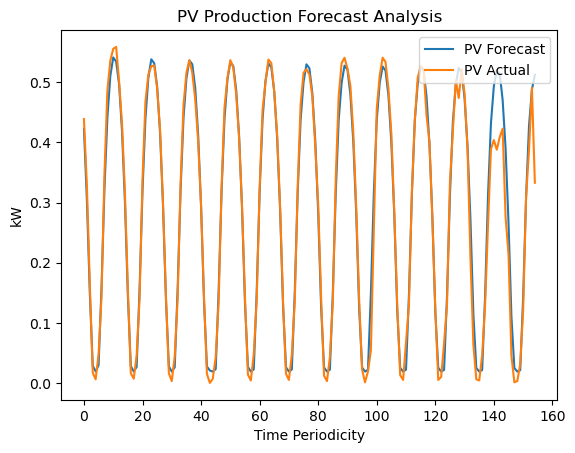

- Root Mean Squared Error: 6.5 %
- R2 Score: 88.69 %
None
Evaluation process Finished
Read the house dataset as dataframe
Read the sun_Position_PT dataset as dataframe
Ingestion of the data is completed
Beggining nan interpolation
Nan interpolation is completed
Beggining Time Variables
Time Variables is completed
Initiating Resample process
Resample process completed
The dataframe that is going to feed the Feature Engineering script has the following columns: ['event_timestamp', 'production_PV', 'elev', 'azim', 'month', 'hour']
Applying feat_eng1
The feat_eng1 is completed
Applying feat_eng2


C:\Users\emparrac\AppData\Local\Temp\ipykernel_148504\3138018875.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_evaluation_metrics = df_evaluation_metrics.append(result_df, ignore_index=True)


The feat_eng2 is completed
Applying feat_eng3
The feat_eng3 is completed
The dataframe that is going to feed the model has 11 columns, and they are: ['production_PV', 'elev', 'azim', 'month', 'production_PV_24h', 'production_PV_48h', '7days_mean_PV', 'sum_pv_day_before', 'std_pv_day_before', 'cos_hour', 'sin_hour']
Initializing forecasting_logic logic implementaion
forecasting_logic Completed
Initiating Train, Validation, and Test Split
Train, Validation, and Test Split Finished
Initiating Data Normalization
Data Normalization Done
Initiating LSTM Model Training
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                19456     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Den

INFO:tensorflow:Assets written to: model\assets


88/88 [==============================] - 16s 138ms/step - loss: 0.0244 - root_mean_squared_error: 0.1562 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1248
Epoch 2/10
86/88 [============================>.] - ETA: 0s - loss: 0.0205 - root_mean_squared_error: 0.1432INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


88/88 [==============================] - 11s 129ms/step - loss: 0.0207 - root_mean_squared_error: 0.1437 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1130
Epoch 3/10
85/88 [===========================>..] - ETA: 0s - loss: 0.0200 - root_mean_squared_error: 0.1413INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


88/88 [==============================] - 9s 108ms/step - loss: 0.0200 - root_mean_squared_error: 0.1415 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1070
Epoch 4/10
88/88 [==============================] - 2s 20ms/step - loss: 0.0199 - root_mean_squared_error: 0.1410 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1084
Epoch 5/10
88/88 [==============================] - 1s 11ms/step - loss: 0.0199 - root_mean_squared_error: 0.1411 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1313
Epoch 6/10
88/88 [==============================] - 1s 10ms/step - loss: 0.0198 - root_mean_squared_error: 0.1407 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1120
Epoch 7/10
83/88 [===========================>..] - ETA: 0s - loss: 0.0197 - root_mean_squared_error: 0.1402INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


88/88 [==============================] - 7s 82ms/step - loss: 0.0195 - root_mean_squared_error: 0.1396 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1058
Epoch 8/10
88/88 [==============================] - 1s 14ms/step - loss: 0.0195 - root_mean_squared_error: 0.1397 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1102
Epoch 9/10
88/88 [==============================] - 1s 11ms/step - loss: 0.0197 - root_mean_squared_error: 0.1403 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1082
Epoch 10/10
88/88 [==============================] - 1s 8ms/step - loss: 0.0197 - root_mean_squared_error: 0.1405 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1081
LSTM Model Trained
Start Evaluation process
13/13 [==============================] - 1s 7ms/step


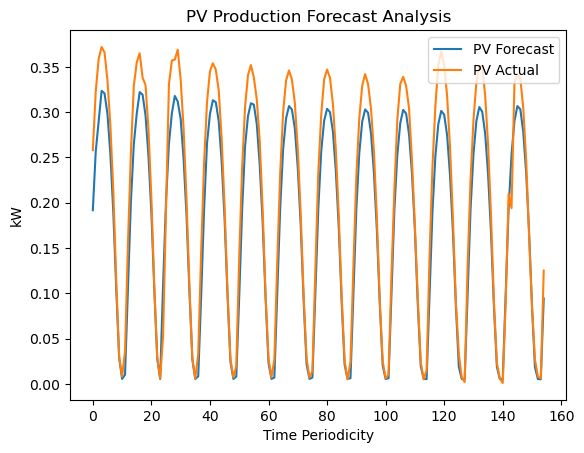

- Root Mean Squared Error: 4.72 %
- R2 Score: 85.12 %
None
Evaluation process Finished
Read the house dataset as dataframe
Read the sun_Position_PT dataset as dataframe
Ingestion of the data is completed
Beggining nan interpolation
Nan interpolation is completed
Beggining Time Variables
Time Variables is completed
Initiating Resample process
Resample process completed
The dataframe that is going to feed the Feature Engineering script has the following columns: ['event_timestamp', 'production_PV', 'elev', 'azim', 'month', 'hour']
Applying feat_eng1
The feat_eng1 is completed
Applying feat_eng2


C:\Users\emparrac\AppData\Local\Temp\ipykernel_148504\3138018875.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_evaluation_metrics = df_evaluation_metrics.append(result_df, ignore_index=True)


The feat_eng2 is completed
Applying feat_eng3
The feat_eng3 is completed
The dataframe that is going to feed the model has 11 columns, and they are: ['production_PV', 'elev', 'azim', 'month', 'production_PV_24h', 'production_PV_48h', '7days_mean_PV', 'sum_pv_day_before', 'std_pv_day_before', 'cos_hour', 'sin_hour']
Initializing forecasting_logic logic implementaion
forecasting_logic Completed
Initiating Train, Validation, and Test Split
Train, Validation, and Test Split Finished
Initiating Data Normalization
Data Normalization Done
Initiating LSTM Model Training
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                19456     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Den

INFO:tensorflow:Assets written to: model\assets


88/88 [==============================] - 19s 142ms/step - loss: 0.0408 - root_mean_squared_error: 0.2020 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1649
Epoch 2/10
88/88 [==============================] - ETA: 0s - loss: 0.0295 - root_mean_squared_error: 0.1718INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


88/88 [==============================] - 9s 105ms/step - loss: 0.0295 - root_mean_squared_error: 0.1718 - val_loss: 0.0266 - val_root_mean_squared_error: 0.1630
Epoch 3/10
88/88 [==============================] - 2s 20ms/step - loss: 0.0285 - root_mean_squared_error: 0.1688 - val_loss: 0.0269 - val_root_mean_squared_error: 0.1639
Epoch 4/10
88/88 [==============================] - 1s 14ms/step - loss: 0.0286 - root_mean_squared_error: 0.1692 - val_loss: 0.0298 - val_root_mean_squared_error: 0.1726
Epoch 5/10
88/88 [==============================] - 1s 9ms/step - loss: 0.0278 - root_mean_squared_error: 0.1667 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1650
Epoch 6/10
88/88 [==============================] - 1s 10ms/step - loss: 0.0275 - root_mean_squared_error: 0.1657 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1705
Epoch 7/10
88/88 [==============================] - 1s 10ms/step - loss: 0.0277 - root_mean_squared_error: 0.1664 - val_loss: 0.0273 - val_root_mean_squared

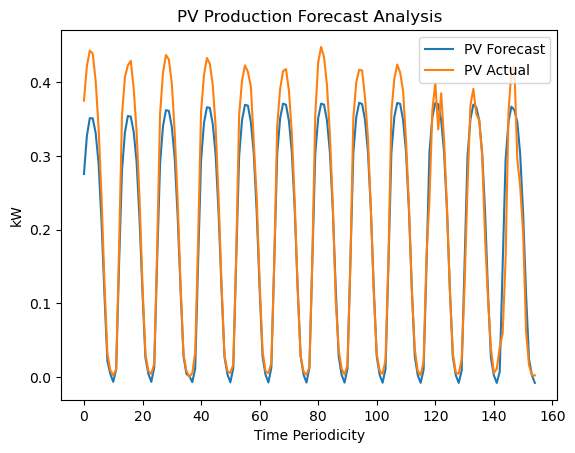

- Root Mean Squared Error: 6.53 %
- R2 Score: 81.61 %
None
Evaluation process Finished


C:\Users\emparrac\AppData\Local\Temp\ipykernel_148504\3138018875.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_evaluation_metrics = df_evaluation_metrics.append(result_df, ignore_index=True)


,RMSE,R2_SCORE
0,6.50,88.69
1,4.72,85.12
2,6.53,81.61


In [12]:
main_function(filelist)